# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable" / "1y"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'timegan_lstm'

In [5]:
# Load real time series
data_train_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_1y.csv')
data_train_real_numpy = dc(data_train_real_df).to_numpy()

data_test_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_3mo.csv')
data_test_real_numpy = dc(data_test_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8747_12_5_timegan_lstm_16_8k.csv', shape=(8747, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(1, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8726_12_5_lstm_autoencoder.csv', shape=(8726, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8759_12_5_fc_vae.csv', shape=(8759, 12, 5))

elif syn_data_type == 'jitter':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'jittered_01.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_train_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal train data:\n')
print(data_train_real_df.describe())

print('\n\nreal test data:\n')
print(data_test_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h        snow_1h  \
count   104964.000000  104964.000000  104964.000000  104964.000000   
mean      3198.733834     283.343847       0.034189       0.000067   
std       1932.971896      11.756874       0.209961       0.000296   
min         47.574738     254.165840       0.000000       0.000000   
25%       1184.408617     271.283047       0.000009       0.000000   
50%       3710.620576     285.982410       0.000434       0.000000   
75%       4926.550740     293.681594       0.004199       0.000044   
max       6459.405012     304.359551       5.326140       0.007977   

          clouds_all  
count  104964.000000  
mean       41.705959  
std        38.665880  
min         0.081840  
25%         0.830981  
50%        26.513073  
75%        85.799234  
max        97.120476  


real train data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 12,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 500,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(
    data_train_real=data_train_real_numpy, 
    data_test_real=data_test_real_numpy,
    data_syn=data_syn_numpy, 
    hyperparameters=hyperparameters, 
    include_baseline=True, 
    verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  12
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  500
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.1663835884214644 // Train Acc: 0.011405109489051095
Val Loss: 0.13610835200490648 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.020800546695389888 // Train Acc: 0.011405109489051095
Val Loss: 0.022283075185602203 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012487148700781629 // Train Acc: 0.011405109489051095
Val Loss: 0.013556882054271066 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00869062442262827 // Train Acc: 0.011405109489051095
Val Loss: 0.009528831380200298 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007084969765324839 // Train Acc: 0.011405109489051095
Val Loss: 0.007648569802233183 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006809658794298456 // Train Acc: 0.011405109489051095
Val Loss: 0.0073008171679890335 // Val Acc: 0.0

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:31<31:39, 211.00s/it]

Epoch: 1
Train Loss: 0.40808229654157246 // Train Acc: 0.02281021897810219
Val Loss: 0.3464258427129072 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0291659686116189 // Train Acc: 0.011405109489051095
Val Loss: 0.03128548528012984 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013591852145317098 // Train Acc: 0.011405109489051095
Val Loss: 0.014715767749722171 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009633381161023013 // Train Acc: 0.011405109489051095
Val Loss: 0.009965951218927169 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007812589983095544 // Train Acc: 0.011405109489051095
Val Loss: 0.008008597336490364 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007277323396827169 // Train Acc: 0.011405109489051095
Val Loss: 0.007285406867809156 // Val Acc: 0.0
***

 20%|██        | 2/10 [07:05<28:22, 212.77s/it]

Epoch: 1
Train Loss: 0.19489527921987712 // Train Acc: 0.011405109489051095
Val Loss: 0.14507277655887746 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03281139920254911 // Train Acc: 0.011405109489051095
Val Loss: 0.03602672045064323 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012344712899219462 // Train Acc: 0.011405109489051095
Val Loss: 0.013694123043130864 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009993276390566552 // Train Acc: 0.011405109489051095
Val Loss: 0.01070298528408303 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00892923866826905 // Train Acc: 0.011405109489051095
Val Loss: 0.009373010122491157 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008297192400583086 // Train Acc: 0.011405109489051095
Val Loss: 0.008722013540511183 // Val Acc: 0.0
**

 30%|███       | 3/10 [10:33<24:36, 210.89s/it]

Epoch: 1
Train Loss: 0.24222830399517378 // Train Acc: 0.0
Val Loss: 0.17911868361646638 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.021938117620378842 // Train Acc: 0.011405109489051095
Val Loss: 0.02415884128662155 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013098338093306109 // Train Acc: 0.011405109489051095
Val Loss: 0.014687166747856228 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008873893923540838 // Train Acc: 0.011405109489051095
Val Loss: 0.009675028956467834 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007411057646573269 // Train Acc: 0.011405109489051095
Val Loss: 0.008047642761512715 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006950297777840093 // Train Acc: 0.011405109489051095
Val Loss: 0.007442813578938299 // Val Acc: 0.0
****************

 40%|████      | 4/10 [14:03<21:03, 210.67s/it]

Epoch: 1
Train Loss: 0.14561759936113428 // Train Acc: 0.011405109489051095
Val Loss: 0.10760653358610238 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02730935438107835 // Train Acc: 0.011405109489051095
Val Loss: 0.030979789300438237 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011314243469540247 // Train Acc: 0.011405109489051095
Val Loss: 0.012329555390512241 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009006198156577447 // Train Acc: 0.011405109489051095
Val Loss: 0.009708206566488919 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008198278391458447 // Train Acc: 0.011405109489051095
Val Loss: 0.008638707160785356 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007850338402374165 // Train Acc: 0.011405109489051095
Val Loss: 0.008147285402040272 // Val Acc: 0.0

 50%|█████     | 5/10 [17:34<17:32, 210.54s/it]

Epoch: 1
Train Loss: 0.13392097369026745 // Train Acc: 0.011405109489051095
Val Loss: 0.10891816504847478 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.029186651987587884 // Train Acc: 0.011405109489051095
Val Loss: 0.03235902078449726 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012350013155411984 // Train Acc: 0.011405109489051095
Val Loss: 0.013576089719529538 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008800312671487485 // Train Acc: 0.011405109489051095
Val Loss: 0.00960671334691784 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007659278127677521 // Train Acc: 0.011405109489051095
Val Loss: 0.008170948124161977 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0069536315149756785 // Train Acc: 0.011405109489051095
Val Loss: 0.007352102253421703 // Val Acc: 0.0

 60%|██████    | 6/10 [21:05<14:03, 210.78s/it]

Epoch: 1
Train Loss: 0.09431249704755788 // Train Acc: 0.011405109489051095
Val Loss: 0.08810141638797872 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.023750761158451657 // Train Acc: 0.011405109489051095
Val Loss: 0.025923799805562284 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01213972572573753 // Train Acc: 0.011405109489051095
Val Loss: 0.013529107087593088 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00956465501464006 // Train Acc: 0.011405109489051095
Val Loss: 0.010037546686362475 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008209074615844166 // Train Acc: 0.011405109489051095
Val Loss: 0.008502822091994697 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0075830451206875165 // Train Acc: 0.011405109489051095
Val Loss: 0.008010708035298568 // Val Acc: 0.0

 70%|███████   | 7/10 [21:57<07:56, 158.78s/it]

INFO: Validation loss did not improve in epoch 122
Early stopping after 122 epochs
Epoch: 1
Train Loss: 0.1746854621740262 // Train Acc: 0.011405109489051095
Val Loss: 0.12235826903762405 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.026930667276419427 // Train Acc: 0.011405109489051095
Val Loss: 0.02953013325767482 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011907487695129167 // Train Acc: 0.011405109489051095
Val Loss: 0.012887932637514657 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010173829567251578 // Train Acc: 0.011405109489051095
Val Loss: 0.010941791950779803 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009335747614917584 // Train Acc: 0.011405109489051095
Val Loss: 0.009925143611754346 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008572614424178771

 80%|████████  | 8/10 [25:28<05:50, 175.45s/it]

Epoch: 1
Train Loss: 0.22234131490648554 // Train Acc: 0.011405109489051095
Val Loss: 0.17113299034270527 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.032392486831322856 // Train Acc: 0.011405109489051095
Val Loss: 0.03596222565016326 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012650248882646271 // Train Acc: 0.011405109489051095
Val Loss: 0.013963668504455948 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010573515445452836 // Train Acc: 0.011405109489051095
Val Loss: 0.011421761129681459 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009571687063460585 // Train Acc: 0.011405109489051095
Val Loss: 0.01007985376396819 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008783983223031472 // Train Acc: 0.011405109489051095
Val Loss: 0.009080105981625178 // Val Acc: 0.0


 90%|█████████ | 9/10 [28:59<03:06, 186.48s/it]

Epoch: 1
Train Loss: 0.3494212408991952 // Train Acc: 0.02281021897810219
Val Loss: 0.26421366336152835 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028622950039749597 // Train Acc: 0.011405109489051095
Val Loss: 0.03096781232777764 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012780875578967949 // Train Acc: 0.011405109489051095
Val Loss: 0.01394311708795345 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0106559843687429 // Train Acc: 0.011405109489051095
Val Loss: 0.01162413479280932 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00911164813612105 // Train Acc: 0.011405109489051095
Val Loss: 0.009899194660486983 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008095324951662498 // Train Acc: 0.011405109489051095
Val Loss: 0.008949064738664995 // Val Acc: 0.0
******

100%|██████████| 10/10 [32:30<00:00, 195.03s/it]


Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.15845979037418212 // Train Acc: 0.014269406392694063
Val Loss: 0.09614819347519767 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.030899900581568617 // Train Acc: 0.014269406392694063
Val Loss: 0.028389881263402375 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014811357296684324 // Train Acc: 0.014269406392694063
Val Loss: 0.013558025802062317 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010952222084447946 // Train Acc: 0.014269406392694063
Val Loss: 0.009503958137197928 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009327071362183553 // Train Acc: 0.014269406392694063
Val Loss: 0.007952105956660075 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008651714295693185 // Train Acc: 0.014269406392694063
Val Loss: 0.0071399485480717634 // Val Acc: 0

 10%|█         | 1/10 [00:34<05:07, 34.22s/it]

INFO: Validation loss did not improve in epoch 98
Early stopping after 98 epochs
Epoch: 1
Train Loss: 0.46138461357722543 // Train Acc: 0.028538812785388126
Val Loss: 0.33221684138883245 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03705132484742223 // Train Acc: 0.014269406392694063
Val Loss: 0.03159212666479024 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014550721905402601 // Train Acc: 0.014269406392694063
Val Loss: 0.01199410811743953 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011990151949095026 // Train Acc: 0.014269406392694063
Val Loss: 0.009928247040476311 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010663855110176043 // Train Acc: 0.014269406392694063
Val Loss: 0.008878337939015844 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009829855508587778 //

 20%|██        | 2/10 [03:30<15:40, 117.58s/it]

Epoch: 1
Train Loss: 0.17881353896910743 // Train Acc: 0.014269406392694063
Val Loss: 0.1183706659823656 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03221713371370753 // Train Acc: 0.014269406392694063
Val Loss: 0.028068699179725213 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015878245972318055 // Train Acc: 0.014269406392694063
Val Loss: 0.01422825361686674 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012155658068968893 // Train Acc: 0.014269406392694063
Val Loss: 0.010069208769974384 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.01014313696815577 // Train Acc: 0.014269406392694063
Val Loss: 0.00822223573923111 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008834691193554397 // Train Acc: 0.014269406392694063
Val Loss: 0.007139189088378441 // Val Acc: 0.0
***

 30%|███       | 3/10 [06:25<16:49, 144.15s/it]

Epoch: 1
Train Loss: 0.21623541266746718 // Train Acc: 0.014269406392694063
Val Loss: 0.13910014595497738 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03579247596176111 // Train Acc: 0.014269406392694063
Val Loss: 0.030527005649425766 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015069443605984795 // Train Acc: 0.014269406392694063
Val Loss: 0.012767818049443038 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01170721976139655 // Train Acc: 0.014269406392694063
Val Loss: 0.009725928585976363 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010134353925958786 // Train Acc: 0.014269406392694063
Val Loss: 0.00837953332811594 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009341331262069172 // Train Acc: 0.014269406392694063
Val Loss: 0.007692309380085631 // Val Acc: 0.0
*

 40%|████      | 4/10 [09:22<15:40, 156.76s/it]

Epoch: 1
Train Loss: 0.09756513085369378 // Train Acc: 0.014269406392694063
Val Loss: 0.06624281386082823 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028322398237305688 // Train Acc: 0.014269406392694063
Val Loss: 0.023461165380748834 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013354088717191289 // Train Acc: 0.014269406392694063
Val Loss: 0.011744148957289077 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011134753661276985 // Train Acc: 0.014269406392694063
Val Loss: 0.009323029241270639 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009792034797313023 // Train Acc: 0.014269406392694063
Val Loss: 0.007950474613938819 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008622184895472304 // Train Acc: 0.014269406392694063
Val Loss: 0.006954346931624142 // Val Acc: 0.

 50%|█████     | 5/10 [12:17<13:37, 163.56s/it]

Epoch: 1
Train Loss: 0.29417136160988516 // Train Acc: 0.0
Val Loss: 0.18572988496585327 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.038918148441299726 // Train Acc: 0.014269406392694063
Val Loss: 0.03358148170465773 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016375214633314986 // Train Acc: 0.014269406392694063
Val Loss: 0.01380441224371845 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012580613787477352 // Train Acc: 0.014269406392694063
Val Loss: 0.010631449778818271 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.011249932779964554 // Train Acc: 0.014269406392694063
Val Loss: 0.009241521278057586 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.010315592847785755 // Train Acc: 0.014269406392694063
Val Loss: 0.008346318381584504 // Val Acc: 0.0
*****************

 60%|██████    | 6/10 [15:13<11:10, 167.64s/it]

Epoch: 1
Train Loss: 0.5265531100706967 // Train Acc: 0.028538812785388126
Val Loss: 0.3633921605619517 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04735035672103433 // Train Acc: 0.014269406392694063
Val Loss: 0.04116662242873149 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.017632485758598264 // Train Acc: 0.014269406392694063
Val Loss: 0.014828530614348976 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.013309628777120892 // Train Acc: 0.014269406392694063
Val Loss: 0.010954783983867277 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010951625917863831 // Train Acc: 0.014269406392694063
Val Loss: 0.008808477087454362 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.010319979362228043 // Train Acc: 0.014269406392694063
Val Loss: 0.008353717786005951 // Val Acc: 0.0
**

 70%|███████   | 7/10 [18:08<08:30, 170.23s/it]

Epoch: 1
Train Loss: 0.222485225613667 // Train Acc: 0.014269406392694063
Val Loss: 0.14759590480137955 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04223453130181794 // Train Acc: 0.014269406392694063
Val Loss: 0.036644103140993554 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01499156113799032 // Train Acc: 0.014269406392694063
Val Loss: 0.013015615406700156 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011798350268562397 // Train Acc: 0.014269406392694063
Val Loss: 0.009806569602171128 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.01009135241630874 // Train Acc: 0.014269406392694063
Val Loss: 0.008245454914867879 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008920593220436495 // Train Acc: 0.014269406392694063
Val Loss: 0.007149258615787734 // Val Acc: 0.0
***

 80%|████████  | 8/10 [21:02<05:42, 171.48s/it]

INFO: Validation loss did not improve in epoch 494
Early stopping after 494 epochs
Epoch: 1
Train Loss: 0.13351334027571765 // Train Acc: 0.014269406392694063
Val Loss: 0.08618030365217816 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04013344472844035 // Train Acc: 0.014269406392694063
Val Loss: 0.034244894405657596 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014559012694182256 // Train Acc: 0.014269406392694063
Val Loss: 0.012616276330399242 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011115744921004561 // Train Acc: 0.014269406392694063
Val Loss: 0.009642675548622553 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009445756705707475 // Train Acc: 0.014269406392694063
Val Loss: 0.00814197408458726 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008655981239905266

 90%|█████████ | 9/10 [23:58<02:52, 172.87s/it]

Epoch: 1
Train Loss: 0.12860038537174873 // Train Acc: 0.014269406392694063
Val Loss: 0.08179876521568406 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03041009784816471 // Train Acc: 0.014269406392694063
Val Loss: 0.02606923214413903 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01494479028201879 // Train Acc: 0.014269406392694063
Val Loss: 0.014151270492849024 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010945941065863354 // Train Acc: 0.014269406392694063
Val Loss: 0.009951540116559375 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009128039242427576 // Train Acc: 0.014269406392694063
Val Loss: 0.007950731489638036 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008194047792869957 // Train Acc: 0.014269406392694063
Val Loss: 0.0068274267017841336 // Val Acc: 0.0


100%|██████████| 10/10 [26:54<00:00, 161.48s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.19375230919688805 // Train Acc: 0.0
Val Loss: 0.138653356785124 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.022048238422466466 // Train Acc: 0.0
Val Loss: 0.01972160263156349 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01046901435131998 // Train Acc: 0.0
Val Loss: 0.010708041362125765 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00988467758495922 // Train Acc: 0.0
Val Loss: 0.010195409896021539 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00959432195578638 // Train Acc: 0.0
Val Loss: 0.009916087057949467 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009361545974176088 // Train Acc: 0.0
Val Loss: 0.009677935378964652 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.009137964156800753 // Train Acc

 10%|█         | 1/10 [02:51<25:46, 171.79s/it]

Epoch: 1
Train Loss: 0.17995593356623496 // Train Acc: 0.0
Val Loss: 0.13719125403599305 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.018370840081851504 // Train Acc: 0.0
Val Loss: 0.018065492385490375 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011005432898876125 // Train Acc: 0.0
Val Loss: 0.011217501149936155 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009890727463845997 // Train Acc: 0.0
Val Loss: 0.010197303732010452 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009057408028609677 // Train Acc: 0.0
Val Loss: 0.009344705388965932 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007969174409693438 // Train Acc: 0.0
Val Loss: 0.008134395578368144 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.006982742193724841 // Tra

 20%|██        | 2/10 [05:44<22:58, 172.27s/it]

Epoch: 1
Train Loss: 0.19936666409718937 // Train Acc: 0.0
Val Loss: 0.15442660423842344 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.026559615967004267 // Train Acc: 0.0
Val Loss: 0.025450492633337325 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011864858236138339 // Train Acc: 0.0
Val Loss: 0.012159447769888422 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010685096493790344 // Train Acc: 0.0
Val Loss: 0.011042588610540737 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010204566866967435 // Train Acc: 0.0
Val Loss: 0.010584866827015172 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009809216680047719 // Train Acc: 0.0
Val Loss: 0.010201202040876855 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.009463984406548956 // Tra

 30%|███       | 3/10 [08:36<20:06, 172.39s/it]

Epoch: 1
Train Loss: 0.14539554004119412 // Train Acc: 0.0
Val Loss: 0.10323042259974913 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0208206227363925 // Train Acc: 0.0
Val Loss: 0.01996149378405376 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011567291817479005 // Train Acc: 0.0
Val Loss: 0.011741961860521273 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010148604078320404 // Train Acc: 0.0
Val Loss: 0.010399819978258826 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009030024252074971 // Train Acc: 0.0
Val Loss: 0.009278322290629148 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007753634866280269 // Train Acc: 0.0
Val Loss: 0.007912740238349546 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.006833880456147468 // Train 

 40%|████      | 4/10 [11:29<17:14, 172.45s/it]

Epoch: 1
Train Loss: 0.4971055206098513 // Train Acc: 0.0
Val Loss: 0.38979951576753097 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0273531072147905 // Train Acc: 0.0
Val Loss: 0.02564255813644691 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012810972302335582 // Train Acc: 0.0
Val Loss: 0.012888789244673468 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010492288434163553 // Train Acc: 0.0
Val Loss: 0.01069821740754626 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009396478618265525 // Train Acc: 0.0
Val Loss: 0.009611351538280194 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008514543054370235 // Train Acc: 0.0
Val Loss: 0.008712292686951431 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.007613491241450179 // Train Ac

 50%|█████     | 5/10 [14:22<14:22, 172.50s/it]

Epoch: 1
Train Loss: 0.2773463657321451 // Train Acc: 0.0
Val Loss: 0.1995942378585989 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.026877756553731823 // Train Acc: 0.0
Val Loss: 0.024458302608267826 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0116239999927002 // Train Acc: 0.0
Val Loss: 0.011979742534458637 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010429113412267405 // Train Acc: 0.0
Val Loss: 0.01081379336220297 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00986154607526924 // Train Acc: 0.0
Val Loss: 0.0102428284262053 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009393326240723535 // Train Acc: 0.0
Val Loss: 0.009755129684609445 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.008939700416973942 // Train Acc: 

 60%|██████    | 6/10 [17:14<11:29, 172.48s/it]

Epoch: 1
Train Loss: 0.24403086005280553 // Train Acc: 0.0
Val Loss: 0.170496320318092 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.024720876571216268 // Train Acc: 0.0
Val Loss: 0.02374607642943209 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011425162532651738 // Train Acc: 0.0
Val Loss: 0.011682642962444912 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009863937816893062 // Train Acc: 0.0
Val Loss: 0.010076172996989706 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009379659358360996 // Train Acc: 0.0
Val Loss: 0.00954969950358976 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009071576107637829 // Train Acc: 0.0
Val Loss: 0.009215916756709868 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.008812870890897226 // Train A

 70%|███████   | 7/10 [20:06<08:37, 172.45s/it]

Epoch: 1
Train Loss: 0.19628753683202343 // Train Acc: 0.0
Val Loss: 0.14496512683955107 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.025635763794421878 // Train Acc: 0.0
Val Loss: 0.024380468475547704 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011832433717631518 // Train Acc: 0.0
Val Loss: 0.012107761974700473 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01038984835177626 // Train Acc: 0.0
Val Loss: 0.010659756646914915 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009810893620963986 // Train Acc: 0.0
Val Loss: 0.010078358624807812 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00936985708301096 // Train Acc: 0.0
Val Loss: 0.00963133463043381 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.00894998383312805 // Train A

 80%|████████  | 8/10 [22:59<05:45, 172.62s/it]

Epoch: 1
Train Loss: 0.3901680009822323 // Train Acc: 0.0
Val Loss: 0.29415478001941336 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02219706967251894 // Train Acc: 0.0
Val Loss: 0.02113243266940117 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011420678007140007 // Train Acc: 0.0
Val Loss: 0.011552443177523937 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010252939244800302 // Train Acc: 0.0
Val Loss: 0.010422445308755744 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009617165671916653 // Train Acc: 0.0
Val Loss: 0.009802026877349074 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009167239958735088 // Train Acc: 0.0
Val Loss: 0.009345990453254092 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.008786900621758067 // Train 

 90%|█████████ | 9/10 [25:52<02:52, 172.70s/it]

Epoch: 1
Train Loss: 0.18534760027443437 // Train Acc: 0.0
Val Loss: 0.12670345807617361 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.018318856271094384 // Train Acc: 0.0
Val Loss: 0.01790426850996234 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01150312644671904 // Train Acc: 0.0
Val Loss: 0.011715565892783079 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01021201095275887 // Train Acc: 0.0
Val Loss: 0.010478677414357662 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00958671929850562 // Train Acc: 0.0
Val Loss: 0.009862476443363861 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009007309920677584 // Train Acc: 0.0
Val Loss: 0.009272157866507768 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.008259756588929898 // Train A

100%|██████████| 10/10 [28:45<00:00, 172.53s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.1254850729952619 // Train Acc: 0.005712979890310786
Val Loss: 0.07837150585563744 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.010997177498803306 // Train Acc: 0.005712979890310786
Val Loss: 0.014639687560060444 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008892379313583061 // Train Acc: 0.005712979890310786
Val Loss: 0.011009372770786285 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007756685711046718 // Train Acc: 0.005712979890310786
Val Loss: 0.009386776672566639 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007404763548327627 // Train Acc: 0.005712979890310786
Val Loss: 0.008551846641828032 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007201074724514684 // Train Acc: 0.005712979890310786
Val Loss: 0.008169384474646957 // Val Acc: 0.0

 10%|█         | 1/10 [06:45<1:00:50, 405.59s/it]

Epoch: 1
Train Loss: 0.08907709934048941 // Train Acc: 0.005712979890310786
Val Loss: 0.06949826329946518 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011055745348722506 // Train Acc: 0.005712979890310786
Val Loss: 0.015012634561999756 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008736423660074813 // Train Acc: 0.005712979890310786
Val Loss: 0.011741514091708642 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007829977072804308 // Train Acc: 0.005712979890310786
Val Loss: 0.010100134518271423 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00731976879794675 // Train Acc: 0.005712979890310786
Val Loss: 0.00894783016102498 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0070570174534847685 // Train Acc: 0.005712979890310786
Val Loss: 0.00834778807235553 // Val Acc: 0.0


 20%|██        | 2/10 [08:47<31:47, 238.44s/it]  

INFO: Validation loss did not improve in epoch 149
Early stopping after 149 epochs
Epoch: 1
Train Loss: 0.2150667706569163 // Train Acc: 0.011425959780621572
Val Loss: 0.07930485904216766 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.010698846116120599 // Train Acc: 0.005712979890310786
Val Loss: 0.01395563205347999 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0092412674321982 // Train Acc: 0.005712979890310786
Val Loss: 0.011675739297917223 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008362495445010424 // Train Acc: 0.005712979890310786
Val Loss: 0.010542796219370383 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00793366743038005 // Train Acc: 0.005712979890310786
Val Loss: 0.009943972588242853 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007585919808410789 //

 30%|███       | 3/10 [15:34<36:47, 315.42s/it]

Epoch: 1
Train Loss: 0.19985887883963163 // Train Acc: 0.0
Val Loss: 0.08481612582417096 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011207651820032086 // Train Acc: 0.005712979890310786
Val Loss: 0.015351652790901853 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008858656168700805 // Train Acc: 0.005712979890310786
Val Loss: 0.01154689013492316 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007977522726718105 // Train Acc: 0.005712979890310786
Val Loss: 0.010257997960947892 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007478821147646128 // Train Acc: 0.005712979890310786
Val Loss: 0.009180953589213245 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007160690169882751 // Train Acc: 0.005712979890310786
Val Loss: 0.00841590079396744 // Val Acc: 0.0
*****************

 40%|████      | 4/10 [22:21<35:09, 351.56s/it]

Epoch: 1
Train Loss: 0.08799710451970916 // Train Acc: 0.005712979890310786
Val Loss: 0.06950333303607562 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01110539600292265 // Train Acc: 0.005712979890310786
Val Loss: 0.014716879505773677 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008775168955981582 // Train Acc: 0.005712979890310786
Val Loss: 0.010905930977862547 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007925452270342456 // Train Acc: 0.005712979890310786
Val Loss: 0.009512790622573127 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0075919771771511945 // Train Acc: 0.005712979890310786
Val Loss: 0.00897964250351138 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007348424441439068 // Train Acc: 0.005712979890310786
Val Loss: 0.008530082119464436 // Val Acc: 0.0

 50%|█████     | 5/10 [29:08<30:58, 371.62s/it]

Epoch: 1
Train Loss: 0.09764694280486547 // Train Acc: 0.005712979890310786
Val Loss: 0.0659405485014705 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.010799281377008208 // Train Acc: 0.005712979890310786
Val Loss: 0.014498319976743968 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009064513678114242 // Train Acc: 0.005712979890310786
Val Loss: 0.011314978823065758 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00853960307368624 // Train Acc: 0.005712979890310786
Val Loss: 0.010136010895674938 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008236389810119805 // Train Acc: 0.005712979890310786
Val Loss: 0.009562531808007728 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007866312512383887 // Train Acc: 0.005712979890310786
Val Loss: 0.009197763934293213 // Val Acc: 0.0


 60%|██████    | 6/10 [35:58<25:39, 384.84s/it]

Epoch: 1
Train Loss: 0.11479363356201043 // Train Acc: 0.005712979890310786
Val Loss: 0.07537364576231032 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011234373400554783 // Train Acc: 0.005712979890310786
Val Loss: 0.015355485731133205 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008285955457830669 // Train Acc: 0.005712979890310786
Val Loss: 0.009939500541590592 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007616287364962407 // Train Acc: 0.005712979890310786
Val Loss: 0.008792055154438405 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007301284924257629 // Train Acc: 0.005712979890310786
Val Loss: 0.008323477266137214 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007097850106758707 // Train Acc: 0.005712979890310786
Val Loss: 0.008128373835728887 // Val Acc: 0.

 70%|███████   | 7/10 [42:47<19:37, 392.60s/it]

Epoch: 1
Train Loss: 0.23170945554004618 // Train Acc: 0.0
Val Loss: 0.10311489300254513 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01199345020479412 // Train Acc: 0.005712979890310786
Val Loss: 0.01678057385416811 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009333775292995165 // Train Acc: 0.005712979890310786
Val Loss: 0.011676968773826957 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008276775785359184 // Train Acc: 0.005712979890310786
Val Loss: 0.009729166549411328 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007834255655544726 // Train Acc: 0.005712979890310786
Val Loss: 0.00918853365103988 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007611459272639516 // Train Acc: 0.005712979890310786
Val Loss: 0.008891759385519168 // Val Acc: 0.0
******************

 80%|████████  | 8/10 [45:43<10:47, 323.68s/it]

INFO: Validation loss did not improve in epoch 216
Early stopping after 216 epochs
Epoch: 1
Train Loss: 0.1262512127877344 // Train Acc: 0.005712979890310786
Val Loss: 0.08734116571791031 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011921159190107035 // Train Acc: 0.005712979890310786
Val Loss: 0.016221074421670947 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009402040976365275 // Train Acc: 0.005712979890310786
Val Loss: 0.012032933190793675 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008503524650618693 // Train Acc: 0.005712979890310786
Val Loss: 0.010460101355634192 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007937029740578194 // Train Acc: 0.005712979890310786
Val Loss: 0.009660436223973246 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00765324411428511

 90%|█████████ | 9/10 [48:38<04:37, 277.36s/it]

INFO: Validation loss did not improve in epoch 215
Early stopping after 215 epochs
Epoch: 1
Train Loss: 0.22015774957290843 // Train Acc: 0.011425959780621572
Val Loss: 0.09425593299024246 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.011586998526127821 // Train Acc: 0.005712979890310786
Val Loss: 0.015848984503570723 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009075763596177537 // Train Acc: 0.005712979890310786
Val Loss: 0.011707923799643622 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00797923800294582 // Train Acc: 0.005712979890310786
Val Loss: 0.010025969679083894 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007669242370811544 // Train Acc: 0.005712979890310786
Val Loss: 0.00937223042060128 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007460603216353129

100%|██████████| 10/10 [55:28<00:00, 332.90s/it]


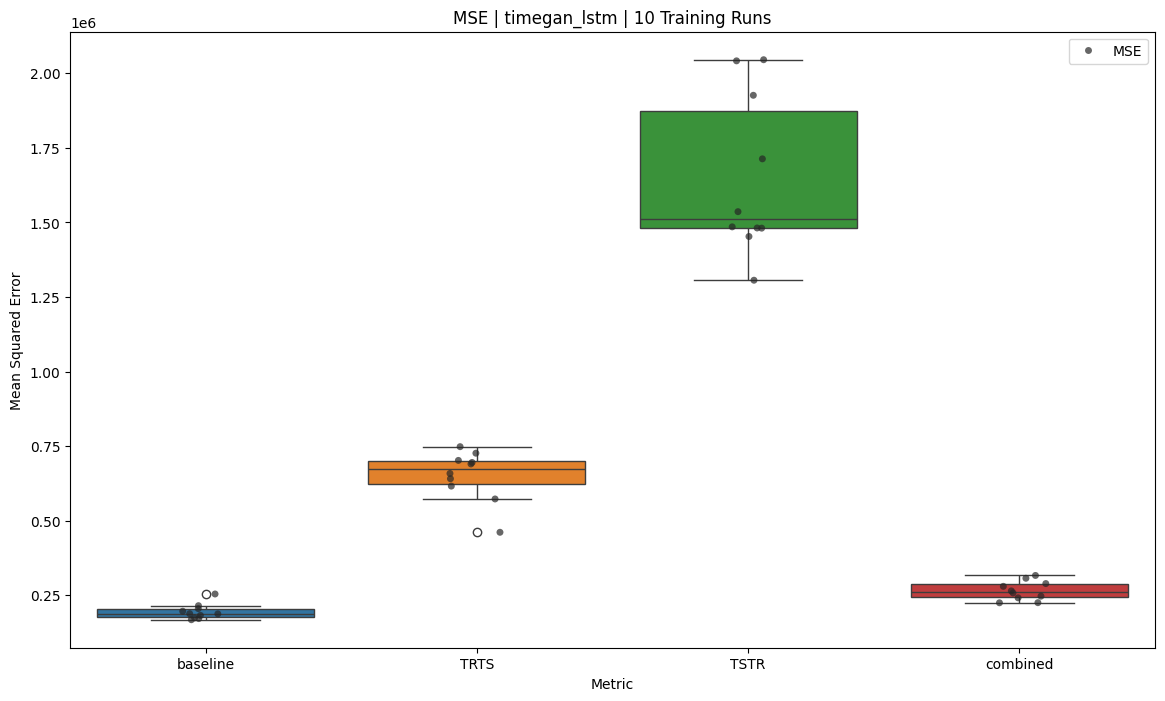

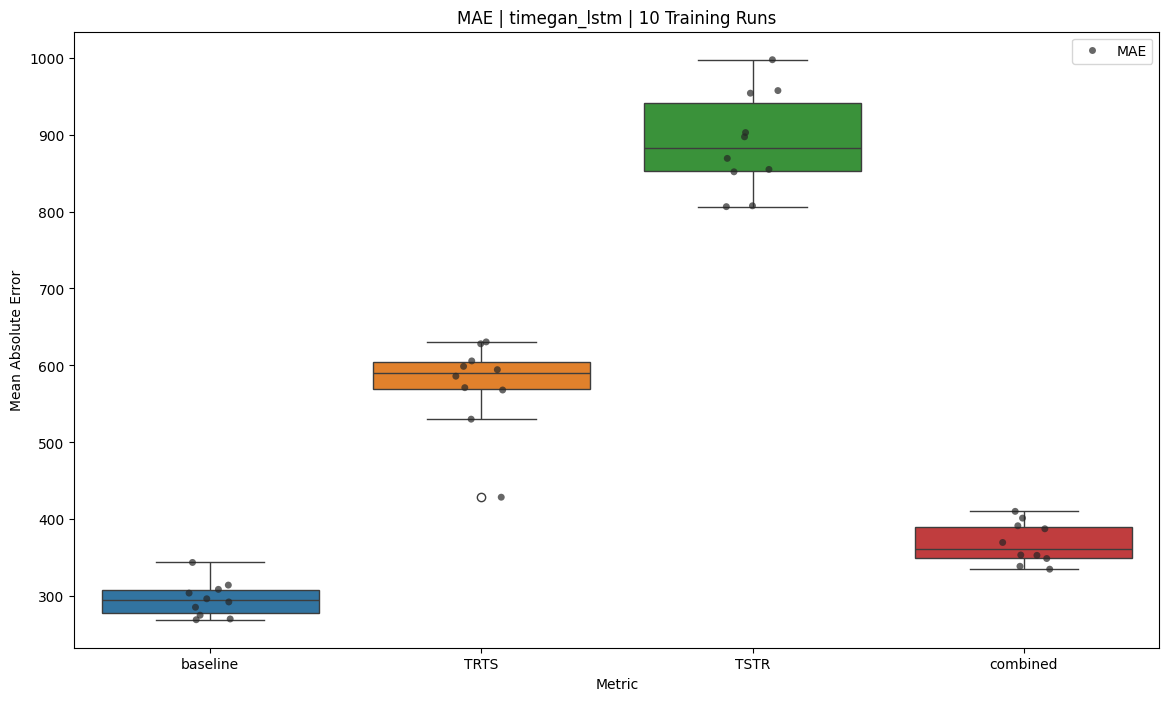

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

In [9]:
0.2*1e06

200000.0